## Overall workflow

- Feed into element detector 
- Feed into credential classifier
- Select suspicious data

<img src="../fig/example2.png" style="width:2000px;height:350px"/>

In [1]:
import os
os.chdir('..')
os.environ["CUDA_VISIBLE_DEVICES"]="1" 

In [2]:
from detectron2_1.datasets import WebMapper
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
import funcy
from IPython.display import clear_output
from detectron2.utils.visualizer import Visualizer
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from pycocotools import cocoeval, coco
from detectron2.data import build_detection_test_loader, MetadataCatalog, DatasetCatalog
import numpy as np
import tldextract
import pickle
import torch
import torch.nn.functional as F
import time
from collections import OrderedDict
import random
import shutil
from IPython.display import clear_output

In [3]:
from credential_classifier.bit_pytorch.models import FCMaxPool
from credential_classifier.bit_pytorch.grid_divider import read_img_reverse

In [7]:
from credential import *
from element_detector import *
from detectron2_1.AL.AL_select import topn, kmeans_plus, core_set
from layout_matcher.heuristic import layout_heuristic

## Load models

In [6]:
ele_cfg, ele_model = element_config(rcnn_weights_path = 'output/website_lr0.001/model_final.pth', 
                                    rcnn_cfg_path='configs/faster_rcnn_web.yaml')

cls_model = credential_config_screenshot(checkpoint='credential_classifier/output/screenshot/screenshot/BiT-M-R50x1_0.005.pth.tar')


## Get uncertainty and feature embeddings

In [ ]:
entropy_agg = []
margin_agg = []
feature_agg = []

for file in tqdm(os.listdir('datasets/datasets/AL_pool_imgs/')):
    img_path = os.path.join('datasets/datasets/AL_pool_imgs/', file)

    pred_classes, pred_boxes, pred_scores = element_recognition(img=img_path, model=ele_model)

    cls_pred, cls_conf, feature = credential_classifier_al(img_path, pred_boxes, pred_classes, cls_model)
    
    cls_conf = cls_conf[0].numpy()
    
    entropy = -np.sum(cls_conf * np.log2(cls_conf), axis=-1).item() # entropy
    margin = 1. - (cls_conf[cls_conf.argsort()[::-1][0]] - cls_conf[cls_conf.argsort()[::-1][1]]) # 1 - (top1-top2)
    
    entropy_agg.append(entropy)
    margin_agg.append(margin)
    feature_agg.append(feature.detach().cpu().numpy()[0])


 11%|█         | 5419/49213 [18:26<2:16:45,  5.34it/s] 

In [20]:
entropy_agg = np.asarray(entropy_agg)
margin_agg = np.asarray(margin_agg)
feature_agg = np.asarray(feature_agg)

In [23]:
np.save('./results/entropy_al.npy', entropy_agg)
np.save('./results/margin_al.npy', margin_agg)
np.save('./results/feature_al.npy', feature_agg)
np.save('./results/al_files.npy', np.asarray(os.listdir('datasets/datasets/AL_pool_imgs/')))

## TopN / Core Set / Kmeans++ select

In [29]:
c_sets = core_set(S=entropy_agg, feat=feature_agg, N=5000)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3600
3700
3800
3900
4000
4100
4300
4400
4500
4600
4700
4800
4900
5000


In [33]:
len(c_sets)

5000

In [34]:
np.save('./results/entropy_select5000_coreset.npy', c_sets)

In [20]:
selected_imgs = np.asarray(os.listdir('datasets/datasets/AL_pool_imgs/'))[np.asarray(c_sets)]

FileNotFoundError: [Errno 2] No such file or directory: './datasets/AL_pool_imgs/'

In [36]:
if os.path.exists('./results/selected_img.txt'):
    os.unlink('./results/selected_img.txt')
    
for img in tqdm(selected_imgs):
    with open('./results/selected_img.txt', 'a+') as f:
        f.write(img)
        f.write('\n')

In [40]:
os.makedirs('datasets/datasets/AL_selected', exist_ok=True)

for img in tqdm(selected_imgs):
    shutil.copyfile(os.path.join('datasets/datasets/AL_pool_imgs/', img), 
                    os.path.join('datasets/datasets/AL_selected', img))

In [41]:
!tar -czvf datasets/AL_selected.tar.gz datasets/AL_selected

datasets/AL_selected/dreamhost.png
datasets/AL_selected/Alibaba+2020-09-16-13`11`22.png
datasets/AL_selected/clavier-arab.png
datasets/AL_selected/WeTransfer+2020-09-02-12`14`02.png
datasets/AL_selected/wordtohtml.png


In [ ]:
!tar -czvf datasets/AL_pool_imgs.tar.gz datasets/AL_pool_imgs

## Visualization of selected images

In [19]:
c_sets_copy = np.load('./results/entropy_select5000_coreset.npy')

In [266]:
selected_imgs = np.asarray(os.listdir('datasets/datasets/AL_pool_imgs/'))[np.asarray(c_sets_copy)]

In [29]:
class_dict = {0:'credential', 1:'noncredential'}
selected_imgs = os.listdir('./datasets/datasets/AL_selected/')

In [30]:
len(selected_imgs)

1800

In [32]:
num_boxes = []
cre_preds = []
cre_confs = []

for path in tqdm(selected_imgs):
    img_path = os.path.join('./datasets/datasets/AL_selected/', path)
    # element detector
    pred_classes, pred_boxes, pred_scores = element_recognition(img=img_path,
                                                                model=ele_model)
    # crp classifier
    cls_pred, cls_conf, feature = credential_classifier_al(img_path, pred_boxes, pred_classes, cls_model)
    # crp heuristic
    pattern_ct, len_input = layout_heuristic(pred_boxes, pred_classes)
    if len_input == 0:
        rule_pred = 1
    elif pattern_ct >= 2:
        rule_pred = 0
    else:
        rule_pred = cls_pred
    
    num_boxes.append(len(pred_boxes))
    cre_preds.append(cls_pred)
    cre_confs.append(torch.max(cls_conf).item())
    
    # If credential heuristic prediction is not equal to classifier prediction --> wrong prediction by classifier
    if rule_pred != cls_pred:
        del cls_pred, cls_conf, feature, pred_classes, pred_boxes, pred_scores, rule_pred
        continue

    # only check high confidence ones, low confidence ones all keep
    if torch.max(cls_conf).item() > 0.8: 
                
        check = cv2.imread(img_path)
        for j, box in enumerate(pred_boxes):
            cv2.rectangle(check, (box[0], box[1]), (box[2], box[3]), (36, 255, 12), 2)
            cv2.putText(check, str(pred_classes[j].item()), (box[0], box[1]), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
    
        plt.figure(figsize=(20,20))
        plt.imshow(check[:, :, ::-1])
        plt.title('Prediction category: {} with prediction confidence: {:.4f}'.format(class_dict[cls_pred], torch.max(cls_conf).item()))
        plt.show()
        
        # high confidence keep only wrong prediction
        y = input() 
        if y == 'r':
            os.unlink(img_path) # remove correct predicted ones

        clear_output()
        
    del cls_pred, cls_conf, feature, pred_classes, pred_boxes, pred_scores, rule_pred

100%|██████████| 1168/1168 [1:23:17<00:00,  4.28s/it]


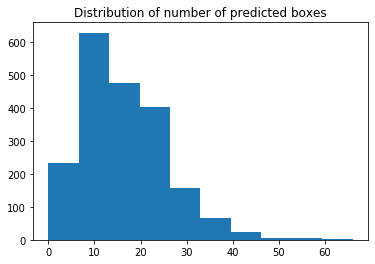

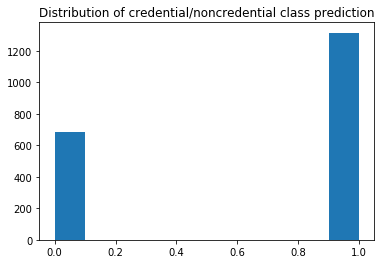

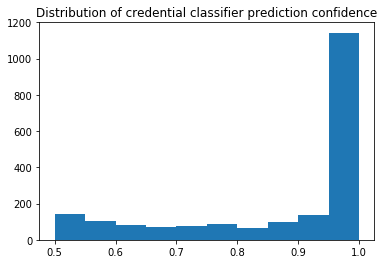

In [252]:
plt.hist(num_boxes)
plt.title('Distribution of number of predicted boxes')
plt.show()
plt.hist(cre_preds)
plt.title('Distribution of credential/noncredential class prediction')
plt.show()
plt.hist(cre_confs)
plt.title('Distribution of credential classifier prediction confidence')
plt.show()